# Object Oriented Programming for the Advanced TSA Security Model

We will design objects for each stage of the process. These objects will hold data and interact with one another as the model is running.

In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats as stats
from matplotlib import style
from tabulate import tabulate
from Queue import Queue

In [7]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
# import datetime
import scipy.stats as stats
from matplotlib import style
from tabulate import tabulate
from Queue import Queue


class Durations:
    def __init__(self, pre_check_pct=0.5, metal_detector_pct=0.33):
        d_data = pd.read_pickle('data/D_data.p')
        self.arrivals_reg = d_data['Regular Pax Arrival Times'].copy().dropna()
        self.arrivals_reg_deltas = self.arrivals_reg.diff()[1:]
        self.arrivals_TSA_pre = d_data['TSA Pre-Check Arrival Times'].copy().dropna()
        self.arrivals_TSA_pre_deltas = self.arrivals_TSA_pre.diff()[1:]

        doc_check_deltas_1 = d_data['ID Check Process Time 1'].copy().dropna()
        doc_check_deltas_2 = d_data['ID Check Process Time 2'].copy().dropna()
        self.doc_check_deltas = doc_check_deltas_1.append(doc_check_deltas_2)

        self.mmw_stamps = d_data['Milimeter Wave Scan times'].copy().dropna()
        self.mmw_deltas = self.mmw_stamps.diff()[1:]

        self.x_ray_scan_1_stamps = d_data['X-Ray Scan Time'].copy().dropna()
        self.x_ray_scan_2_stamps = d_data['X-Ray Scan Time.1'].copy().dropna()

        self.x_ray_scan_deltas = self.x_ray_scan_1_stamps.diff()[1:].append(self.x_ray_scan_2_stamps.diff()[1:])

        self.belt_proper_scan_deltas = d_data['Time to get scanned property'].copy()

        self.pre_check_pct = pre_check_pct
        self.metal_detector_pct = metal_detector_pct
        self.false_alarm_rate = 0.3
        self.pre_check_rate = 0.45
        self.random_screen_rate = 0.05

    def gen_arrival_reg_delta(self):
        return np.random.choice(self.arrivals_reg_deltas)

    def gen_arrival_TSA_PRE_delta(self):
        return np.random.choice(self.arrivals_TSA_pre_deltas)

    def gen_doc_check_delta(self):
        return np.random.choice(self.doc_check_deltas)

    def gen_mmw_delta(self):
        return np.random.choice(self.mmw_deltas)

    def gen_x_ray_scan_delta(self):
        return np.random.choice(self.x_ray_scan_deltas)

    def gen_belt_proper_scan_delta(self):
        return np.random.choice(self.belt_proper_scan_deltas)

    def set_pre_check_pct(self, pct):
        self.pre_check_pct = pct

    def gen_zone_d_screen_time(self):
        return stats.chi.rvs(df=3, loc=0, scale=36, size=1).astype(int)[0]

    def gen_bin_placement_time(self):
        return stats.chi.rvs(df=3, loc=0, scale=8, size=1).astype(int)[0]

    def gen_zone_c_screen_time(self):
        return stats.chi.rvs(df=3, loc=0, scale=9, size=1).astype(int)[0]

    def gen_random_screen_time(self):
        return stats.chi.rvs(df=3, loc=0, scale=10, size=1)

    def gen_pre_check_status(self):
        pre_check_status = False
        if np.random.binomial(1, self.pre_check_rate) == 1:
            pre_check_status = True
        return pre_check_status


class BinItem:
    def __init__(self, owner):
        self.location = 0
        self.owner = owner


class Person:
    def __init__(self, ID, durations, pre_check):
        """
        creates a person object.

        Person object holds a list of bins, a Series with wait times, and a series with processing times.

        Parameters:
        -------------
            ID : int
                Person number identifier, assigned to person by generator
            wait_line_areas : list of strings
                list of the names of all the lines where the
            processing_area : list of strings
                list of the names of the processing stations

        """
        self.durations = durations

        self.false_alarm_rate = self.durations.false_alarm_rate
        self.random_screen_rate = self.durations.random_screen_rate

        self.false_alarm = False
        self.random_selection = False
        if np.random.binomial(1, self.false_alarm_rate) == 1:
            self.false_alarm = True
        # random selection
        elif np.random.binomial(1, self.random_screen_rate) == 1:
            self.random_selection = True

        self.ID = ID
        self.scanner_used = None
        self.through_body_scan = False
        self.location = None
        self.time_remaining = None
        self.current_time_waiting = 0
        self.side = None

        self.pre_check = pre_check

        if self.pre_check:
            num_bins = stats.chi.rvs(df=3, loc=0, scale=2, size=1).astype(int)[0]
        else:
            num_bins = stats.chi2.rvs(df=3, loc=0, scale=1, size=1).astype(int)[0]
        # Generates randomly the number of bins
        # integers from chi2
        self.num_bins = num_bins.astype(int)
        # list of bins required by person
        self.bins_off_belt = [BinItem(self) for _ in range(self.num_bins)]
        self.bins_on_belt = []

        self.wait_times = Series()
        self.wait_times.name = 'wait_times'
        self.process_times = Series()
        self.process_times.name = 'process_times'


class ZoneC:
    def __init__(self, durations):
        self.belt_lines = None
        self.name = 'zone_c'
        self.zone_d = None
        self.people = []
        self.durations = durations
        self.stats_collector = None

    def set_connections(self, belt_lines, zone_d, stats_collector):
        if type(belt_lines) != list:
            belt_lines = [belt_lines]
        self.belt_lines = belt_lines
        self.zone_d = zone_d
        self.stats_collector = stats_collector

    def pull(self):
        for line in self.belt_lines:
            persons = line.push(self.name)
            for person in persons:
                if person is not None:
                    self.people.append(person)
                    person.location = self
                    person.process_times[self.name] = self.durations.gen_zone_c_screen_time() * person.num_bins
        persons = self.zone_d.push()
        for person in persons:
            if person is not None:
                self.people.append(person)
                person.process_times[self.name] = self.durations.gen_zone_c_screen_time() * person.num_bins
                person.location = self

    def iterate(self, second):
        for person in self.people:
            if person.time_remaining != 0:
                person.time_remaining -= 1

    def push(self):
        to_push = []
        not_push = []
        for person in self.people:
            if person.time_remaining == 0:
                to_push.append(person)
                person.location = None
            else:
                not_push.append(person)
        self.people = not_push
        return to_push

    def count(self):
        return len(self.people)

    def is_empty(self):
        return self.count() == 0


class ZoneD:
    # multiple additional screenings
    def __init__(self, durations, num_add_screens=1):
        self.num_add_screens = num_add_screens
        self.to_screen = []
        self.post_screen = []
        self.in_screening = []
        self.durations = durations
        self.name = 'zone_d'
        self.zone_c = None
        self.post_scan_lines = None

    def set_connections(self, post_scan_lines, zone_c):
        if type(post_scan_lines) != list:
            post_scan_lines = [post_scan_lines]
        self.post_scan_lines = post_scan_lines
        self.zone_c = zone_c

    def add_to_screening_queue(self, person):
        self.to_screen.append(person)
        person.wait_times[self.name] = 0

    def send_to_station(self, person):
        if len(self.in_screening) < self.num_add_screens:
            self.in_screening.append(person)
            process_time = self.durations.gen_zone_d_screen_time()
            person.time_remaining = process_time
            person.process_times[self.name] = process_time

    def add_to_post_screen(self, person):
        self.post_screen.append(person)

    def push(self):
        people = self.post_screen
        self.post_screen = []
        return people

    def pull(self):
        for line in self.post_scan_lines:
            people = line.push(self.name)
            for person in people:
                self.add_to_screening_queue(person)

    def iterate(self, second):
        stays = []
        leaves = []
        for person in self.in_screening:
            if person.time_remaining == 0:
                leaves.append(person)
            else:
                if person.time_remaining > 0:
                    person.time_remaining -= 1
                stays.append(person)

        for person in leaves:
            self.add_to_post_screen(person)
        self.in_screening = stays
        if len(self.in_screening) < self.num_add_screens and len(self.to_screen) != 0:
            self.send_to_station(self.to_screen.pop(0))

        for person in self.to_screen:
            person.wait_times[self.name] += 1


class PostScanLine:
    def __init__(self, side):
        self.line = []
        self.side = side
        self.name = 'post_scan_line'
        if side == 'left':
            self.left = True
        else:
            self.left = False

        self.zone_c = None
        self.zone_d = None
        self.body_scanners = None
        self.x_ray_belt = None

    def set_connections(self, zone_c, zone_d, body_scanners, x_ray_belt):
        self.zone_c = zone_c
        self.zone_d = zone_d
        if type(body_scanners) != list:
            body_scanners = [body_scanners]
        self.body_scanners = body_scanners
        self.x_ray_belt = x_ray_belt

    def pull(self):
        for scanner in self.body_scanners:
            person = scanner.push(self.side)
            if person is not None:
                self.line.append(person)
                person.location = self
                person.wait_times[self.name] = 0

    def push(self, zone):
        stays = []
        leaves = []
        if zone == 'zone_c':
            for person in self.line:
                if not person.false_alarm and len(person.bins_on_belt) == 0:
                    leaves.append(person)
                    person.location = None
                else:
                    stays.append(person)
        elif zone == 'zone_d':
            for person in self.line:
                if person.false_alarm and len(person.bins_on_belt) == 0:
                    leaves.append(person)
                    person.location = None
                else:
                    stays.append(person)
        else:
            raise ValueError('invalid zone')
        self.line = stays
        return leaves

    def iterate(self, second):
        for person in self.line:
            person.wait_times[self.name] += 1
            self.x_ray_belt.person_get_available_bins(person)

    def is_empty(self):
        return len(self.line) == 0

    def get_count(self):
        return len(self.line)


class XRayBelt:
    def __init__(self, durations, pre_scan_spots=5):
        self.scanned_bins = []  # 4 bins after begin scanned
        self.scanned_bins_max = 4
        self.scanning = None
        self.pre_scan_spots = pre_scan_spots
        self.pre_scan_q = Queue(maxsize=self.pre_scan_spots)
        self.durations = durations
        self.next_scan_time = self.durations.gen_x_ray_scan_delta()
        self.idle_seconds = []
        self.name = 'x_ray_belt'
        self.bin_placement = None

    def set_connections(self, bin_placement):
        self.bin_placement = bin_placement

    def iterate(self, second):
        if self.next_scan_time == 0:
            self.next_scan_time = self.durations.gen_x_ray_scan_delta()
            # move from scanning to scanned
            if len(self.scanned_bins) < self.scanned_bins_max:
                if self.scanning is not None:
                    self.scanned_bins.append(self.scanning)
                if not self.pre_scan_q.empty():
                    self.scanning = self.pre_scan_q.get()
                else:
                    self.scanning = None

        else:
            if self.next_scan_time > 0:
                self.next_scan_time -= 1
        if self.scanning is None and self.pre_scan_q.empty():
            self.idle_seconds.append(second)

    def get_open_spots(self):
        return self.pre_scan_spots - self.pre_scan_q.qsize()

    def has_vacancy(self):
        return self.get_open_spots() != 0

    def person_get_available_bins(self, person):
        bins_stay = []
        for bin_item in self.scanned_bins:
            if bin_item.owner == person:
                person.bins_on_belt.remove(bin_item)
                person.bins_off_belt.append(bin_item)
            else:
                bins_stay.append(bin_item)
        self.scanned_bins = bins_stay

    def place_bin(self, bin_item):
        if self.has_vacancy():
            self.pre_scan_q.put(bin_item)
        else:
            raise RuntimeError('Bin placement failed on x-ray belt')


class BinPlacement:
    def __init__(self, side, durations):
        self.belt_line = None
        self.pre_scan_line = None
        self.x_ray_belt = None
        self.side = side
        self.person = None
        self.durations = durations
        self.bin_time = 0
        self.name = 'bin_placement'

    def set_connections(self, belt_line, pre_scan_line, x_ray_belt):
        self.x_ray_belt = x_ray_belt
        self.pre_scan_line = pre_scan_line
        self.belt_line = belt_line

    def push(self):
        if self.person is not None:
            if len(self.person.bins_on_belt) == self.person.num_bins:
                curr_person = self.person
                self.person = None
                self.bin_time = 0
                curr_person.location = None
                return curr_person
        else:
            return None

    def pull(self):
        if self.person is None:
            person = self.belt_line.push()
            if person is not None:
                self.person = person
                self.person.location = self
                self.person.side = self.side
                self.bin_time = self.durations.gen_bin_placement_time()
                self.person.process_times[self.name] = self.bin_time * self.person.num_bins

    def iterate(self, second):
        if self.person is not None:
            if (len(self.person.bins_on_belt) < self.person.num_bins) and (len(self.person.bins_off_belt) > 0):
                if self.x_ray_belt.has_vacancy() and self.bin_time == 0:
                    bin_to_place = self.person.bins_off_belt.pop(0)
                    self.x_ray_belt.place_bin(bin_to_place)
                    self.person.bins_on_belt.append(bin_to_place)
                else:
                    if self.bin_time != 0:
                        self.bin_time -= 1


class Scanner:
    def __init__(self, durations, name):
        self.person = None
        self.idle_seconds = []
        self.durations = durations
        self.pre_scan_line = None
        self.post_scan_lines = None
        self.name = name

    def set_connections(self, pre_scan_line, post_scan_lines):
        self.pre_scan_line = pre_scan_line
        self.post_scan_lines = post_scan_lines

    def is_empty(self):
        return self.person is None

    def is_in_use(self):
        return not self.is_empty()

    def push(self, side):
        person_to_push = None
        if self.person is not None:
            if self.person.time_remaining == 0:
                if self.person.side == side:
                    person_to_push = self.person
                    person_to_push.location = None
                    self.person = None
        return person_to_push

    def pull(self):
        if self.person is None:
            self.person = self.pre_scan_line.push()
            if self.person is not None:
                self.person.scanner_used = self.name
                self.person.location = self
                if self.name == 'mmw':
                    self.person.time_remaining = self.durations.gen_mmw_delta()
                elif self.name == 'metal_detector':
                    self.person.time_remaining = self.durations.gen_mmw_delta() * self.durations.metal_detector_pct
                self.person.process_times['body_scanner'] = self.person.time_remaining

    def iterate(self, second):
        if self.person is not None:
            if self.person.time_remaining != 0:
                self.person.time_remaining -= 1
        else:
            self.idle_seconds.append(second)


class PreScanLine:
    def __init__(self, maxsize=8):
        self.name = 'pre_scan_line'
        self.line = []
        self.maxsize = maxsize
        self.scanner = None
        self.bin_placement = None

    def set_connections(self, scanner, bin_placement):
        self.bin_placement = bin_placement
        self.scanner = scanner

    def is_empty(self):
        return len(self.line) == 0

    def is_full(self):
        return len(self.line) == self.maxsize

    def get_count(self):
        return len(self.line)

    def push(self):
        if not self.is_empty():
            person_to_push = self.line.pop(0)
            person_to_push.location = None
            return person_to_push

    def pull(self):
        if not self.is_full():
            person = self.bin_placement.push()
            if person is not None:
                self.line.append(person)
                person.location = self
                person.wait_times[self.name] = 0

    def iterate(self, second):
        for person in self.line:
            person.wait_times[self.name] += 1


class BeltLine:
    def __init__(self, maxsize=20):
        self.line = []
        self.maxsize = maxsize
        self.doc_check = None
        self.bin_placement = None
        self.name = 'x_ray_line'

    def set_connections(self, doc_check, bin_placement):
        self.bin_placement = bin_placement
        self.doc_check = doc_check

    def is_empty(self):
        return len(self.line) == 0

    def is_full(self):
        return len(self.line) == self.maxsize

    def get_count(self):
        return len(self.line)

    def push(self):
        if not self.is_empty():
            person_to_push = self.line.pop(0)
            person_to_push.location = None
            return person_to_push

    def pull(self):
        if not self.is_full():
            person = self.doc_check.push()
            if person is not None:
                person.location = self
                person.wait_times[self.name] = 0
                self.line.append(person)

    def iterate(self, second):
        for person in self.line:
            person.wait_times[self.name] += 1


class DocCheck:
    def __init__(self, durations):
        self.person = None
        self.idle_seconds = []
        self.durations = durations
        self.pre_doc_check_process = None
        self.post_doc_check_process = None
        self.name = 'doc_check'

    def set_connections(self, pre_doc_check_process, post_doc_check_process):
        self.pre_doc_check_process = pre_doc_check_process
        self.post_doc_check_process = post_doc_check_process

    def is_empty(self):
        return self.person is None

    def is_in_use(self):
        return not self.is_empty()

    def push(self):
        person_to_push = None
        if self.person is not None:
            if self.person.time_remaining == 0:
                person_to_push = self.person
                person_to_push.location = None
                self.person = None
        return person_to_push

    def pull(self):
        if self.person is None:
            self.person = self.pre_doc_check_process.push()
            if self.person is not None:
                self.person.location = self
                self.person.time_remaining = self.durations.gen_doc_check_delta()
                self.person.process_times[self.name] = self.person.time_remaining

    def iterate(self, second):
        if self.person is not None:
            if self.person.time_remaining != 0:
                self.person.time_remaining -= 1
        else:
            self.idle_seconds.append(second)


class FirstLine:
    def __init__(self):
        self.line = []
        self.out_process = None
        self.in_process = None
        self.name = 'first_line'

    def set_connections(self, in_process, out_process):
        self.in_process = in_process
        self.out_process = out_process

    def is_empty(self):
        return len(self.line) == 0

    def get_count(self):
        return len(self.line)

    def push(self):
        if not self.is_empty():
            person_to_push = self.line.pop(0)
            person_to_push.location = None
            return person_to_push

    def pull(self):
        person = self.in_process.push()
        if person is not None:
            person.location = self
            person.wait_times[self.name] = 0
            self.line.append(person)

    def iterate(self, second):
        for person in self.line:
            person.wait_times[self.name] += 1


class Feeder:
    def __init__(self):
        self.name = 'feeder'
        self.in_processes = None
        self.out_processes = None

        # TODO: Finish Feeder


class StatsCollector:
    def __init__(self):
        self.in_process = None
        self.people_stats = None
        self.q = Queue()
        self.stored_person = None
        self.idle_times = None

    def set_connections(self, in_process):
        self.in_process = in_process

    def pull(self):
        persons = self.in_process.push()
        if persons is not None:
            if type(persons) != list:
                persons = [persons]
            for person in persons:
                if person is not None:
                    self.q.put(person)

    def iterate(self, second):
        while not self.q.empty():
            person = self.q.get()
            s_process = person.process_times
            s_wait = person.wait_times

            df_process = DataFrame(s_process)
            df_wait = DataFrame(s_wait)
            df_process = df_process.T

            df_wait = df_wait.T

            # Set up columns and indexes
            label_process = df_process.index.tolist()[0]
            label_wait = df_wait.index.tolist()[0]

            columns_process = df_process.columns.tolist()
            columns_wait = df_wait.columns.tolist()
            upper_process = [label_process] * len(columns_process)
            upper_wait = [label_wait] * len(columns_wait)
            tuples_process = list(zip(upper_process, columns_process))
            tuples_wait = list(zip(upper_wait, columns_wait))
            df_process.columns = pd.MultiIndex.from_tuples(tuples_process)
            df_wait.columns = pd.MultiIndex.from_tuples(tuples_wait)
            df_process.index = range(len(df_process))
            df_wait.index = range(len(df_wait))

            # merge to full DataFrame
            person_stats = pd.concat([df_process, df_wait], axis=1)

            person_stats.loc[0, ('attributes', 'ID')] = person.ID
            person_stats.loc[0, ('attributes', 'num_bins')] = person.num_bins
            person_stats.loc[0, ('attributes', 'scanner_used')] = person.scanner_used
            person_stats.loc[0, ('attributes', 'pre_check_status')] = person.pre_check
            person_stats.loc[0, ('attributes', 'randomly_selected')] = person.random_selection
            person_stats.loc[0, ('attributes', 'failed_scan')] = person.false_alarm
            person_stats.loc[0,('totals', 'process_time')] = \
                person_stats.loc[0, ('totals', 'process_time')] = \
                person_stats.loc[0:, ('process_times')].sum(axis=1).values[0]
            person_stats.loc[0, ('totals', 'wait_time')] = \
                person_stats.loc[0:, ('wait_times')].sum(axis=1).values[0]
            person_stats.loc[0, ('totals', 'total_time')] = \
                person_stats.loc[0:, ('totals', 'process_time')].values[0] + \
                person_stats.loc[0:, ('totals', 'wait_time')].values[0]

            self.people_stats = pd.concat([self.people_stats, person_stats], ignore_index=True)
            self.people_stats.fillna(value=0, inplace=True)

            del person
            
    def calc_idle_times(self):
        pass


class Generator:
    def __init__(self, durations):
        self.out_process = None
        self.durations = durations
        self.countdown = 0
        self.person_count = 0
        self.next_pre_check_status = False

    def set_connections(self, out_process):
        self.out_process = out_process

    def push(self):
        if self.countdown == 0:
            person = Person(self.person_count, self.durations, self.next_pre_check_status)
            self.person_count += 1
            self.next_pre_check_status = self.durations.gen_pre_check_status()
            if self.next_pre_check_status:
                self.countdown = self.durations.gen_arrival_TSA_PRE_delta()
            else:
                self.countdown = self.durations.gen_arrival_reg_delta()
            return person

    def iterate(self, second):
        if self.countdown != 0:
            self.countdown -= 1

    def pull(self):
        pass


class Model:
    def __init__(self):
        self.durations = Durations()
        self.generator = Generator(self.durations)
        self.first_line = FirstLine()
        self.doc_check = DocCheck(self.durations)
        self.belt_line = BeltLine()
        self.bin_placement = BinPlacement('right', self.durations)
        self.pre_scan_line = PreScanLine()
        self.x_ray_belt = XRayBelt(self.durations)
        self.scanner = Scanner(self.durations, 'mmw')
        self.post_scan_line = PostScanLine('right')
        self.zone_d = ZoneD(self.durations)
        self.zone_c = ZoneC(self.durations)
        self.stats_collector = StatsCollector()
        self.all = None

    def set_connections_single_line(self):
        self.generator.set_connections(self.first_line)
        self.first_line.set_connections(self.generator, self.doc_check)
        self.doc_check.set_connections(self.first_line, self.belt_line)
        self.belt_line.set_connections(self.doc_check, self.bin_placement)
        self.bin_placement.set_connections(self.belt_line, self.pre_scan_line, self.x_ray_belt)
        self.pre_scan_line.set_connections(self.scanner, self.bin_placement)
        self.x_ray_belt.set_connections(self.bin_placement)
        self.scanner.set_connections(self.pre_scan_line, self.post_scan_line)
        self.post_scan_line.set_connections(self.zone_c, self.zone_d, self.scanner, self.x_ray_belt)
        self.zone_d.set_connections(self.post_scan_line, self.zone_c)
        self.zone_c.set_connections(self.post_scan_line, self.zone_d, self.stats_collector)
        self.stats_collector.set_connections(self.zone_c)

    def run_single_line(self, seconds=2000):
        self.set_connections_single_line()
        for i in range(seconds):
            self.stats_collector.pull()
            self.zone_c.pull()
            self.zone_d.pull()
            self.post_scan_line.pull()
            self.scanner.pull()
            self.pre_scan_line.pull()
            self.bin_placement.pull()
            self.belt_line.pull()
            self.doc_check.pull()
            self.first_line.pull()

            self.stats_collector.iterate(i)
            self.zone_c.iterate(i)
            self.zone_d.iterate(i)
            self.post_scan_line.iterate(i)
            self.scanner.iterate(i)
            self.x_ray_belt.iterate(i)
            self.pre_scan_line.iterate(i)
            self.bin_placement.iterate(i)
            self.belt_line.iterate(i)
            self.doc_check.iterate(i)
            self.first_line.iterate(i)
            self.generator.iterate(i)

    def summary_stats(self, mode='print', data_head=False):
        if mode == 'return':
            return self.stats_collector.people_stats.describe().T
        elif mode == 'print':
            if data_head:
                print 'Stats Tables Head:'
                print tabulate(self.stats_collector.people_stats.head(), headers='keys', tablefmt='psql')
            print 'SUMMARY STATISTICS:'
            print tabulate(self.stats_collector.people_stats.drop(('attributes', 'ID'), axis=1).describe().T,
                           headers='keys', tablefmt='psql')

    def summary_plots(self):
        style.use('fivethirtyeight')
        style.use('seaborn-whitegrid')
        style.use('seaborn-notebook')
        people_stats = self.stats_collector.people_stats
        # Total hists
        f, axarr = plt.subplots(1, 3, figsize=(14, 6))
        axarr[0].hist(people_stats.totals.process_time, bins=15, alpha=0.8)
        axarr[0].set_title('Total Time Spent in Security Checks Per Person')
        axarr[1].hist(people_stats.totals.wait_time, bins=15, alpha=0.8)
        axarr[1].set_title('Total Time Spent Waiting Per Person')
        axarr[2].hist(people_stats.totals.process_time, bins=15, alpha=0.8)
        axarr[2].set_title('Total Time Per Person Through Security')
        for ax in axarr.flatten():
            ax.set_ylabel('Frequency')
            ax.set_xlabel('Seconds')

        # Processing station details
        f, axarr = plt.subplots(1, 3, figsize=(14, 6))
        axarr[0].plot(people_stats.process_times.doc_check, alpha=0.4, label='Doc Check')
        axarr[0].plot(people_stats.process_times.bin_placement, alpha=0.4, label='Place Bins on Belt')
        axarr[0].plot(people_stats.process_times.body_scanner, alpha=0.4, label='Body Scan')
        axarr[0].plot(people_stats.process_times.zone_c, alpha=0.4, label='Bag Collection and Exit')
        axarr[0].set_title('Time Spent at Processing Station')

        axarr[1].plot(people_stats.wait_times.first_line, alpha=0.6, label='ID Check')
        axarr[1].plot(people_stats.wait_times.x_ray_line, alpha=0.6, label='Bag X-Ray')
        axarr[1].plot(people_stats.wait_times.pre_scan_line, alpha=0.6, label='Body Scan')
        axarr[1].plot(people_stats.wait_times.post_scan_line, alpha=0.6, label='Bag Collection')
        axarr[1].set_title('Time Spent Waiting Before Processing Station')

        axarr[2].plot(people_stats.wait_times.zone_d[people_stats.wait_times.zone_d != 0].values, alpha=0.6,
                         label='Additional Screening Wait Time')
        axarr[2].plot(people_stats.process_times.zone_d[people_stats.process_times.zone_d != 0].values,
                         alpha=0.6, label='Additional Screening Time')
        axarr[2].set_title('Those Flagged For Screening')

        for ax in axarr.flatten():
            ax.set_ylabel('Seconds')
            ax.set_xlabel('Person Number')
            ax.legend(loc='best')

        f, axarr = plt.subplots(1, 2, figsize=(14, 6))

        axarr[0].plot(people_stats.totals.total_time, alpha=0.6, label='Total Time')
        axarr[0].plot(people_stats.totals.wait_time, alpha=0.6, label='Total Time Waiting')
        axarr[0].plot(people_stats.totals.process_time, alpha=0.6, label='Total Time at Processing Station')
        axarr[0].set_title('Time Spent Per Category For All Travelers')

        axarr[1].plot(people_stats.totals.total_time[~people_stats.attributes.pre_check_status].values,
                      alpha=0.6, label='Total Time Non Pre-Check')
        axarr[1].plot(people_stats.totals.wait_time[~people_stats.attributes.pre_check_status].values,
                      alpha=0.6, label='Time Waiting Non Pre-Check')
        axarr[1].plot(people_stats.totals.process_time[~people_stats.attributes.pre_check_status].values,
                      alpha=0.6, label='Processing Station Time Non Pre-Check')

        axarr[1].plot(people_stats.totals.total_time[people_stats.attributes.pre_check_status].values,
                      alpha=0.6, label='Total Time Pre-Check')
        axarr[1].plot(people_stats.totals.wait_time[people_stats.attributes.pre_check_status].values,
                      alpha=0.6, label='Time Waiting Pre-Check')
        axarr[1].plot(people_stats.totals.process_time[people_stats.attributes.pre_check_status].values,
                      alpha=0.6, label='Processing Station Time Pre-Check')

        axarr[1].set_title('Time Spent Per Category by TSA-PreCheck Status')

        for ax in axarr.flatten():
            ax.set_ylabel('Seconds')
            ax.set_xlabel('Person Number')
            ax.legend(loc='best')

        f, axarr = plt.subplots(1, 2, figsize=(14, 6))

        axarr[0].plot(people_stats.totals.total_time[~people_stats.attributes.failed_scan].values,
                      alpha=0.5, label='Total Time')
        axarr[0].plot(people_stats.totals.wait_time[~people_stats.attributes.failed_scan].values,
                      alpha=0.5, label='Total Time Waiting')
        axarr[0].plot(people_stats.totals.process_time[~people_stats.attributes.failed_scan].values,
                      alpha=0.5, label='Total Time at Processing Station')
        axarr[0].set_title('Time Spent Per Category For Traveler with Failed Scan')

        axarr[1].plot(people_stats.totals.total_time[people_stats.attributes.failed_scan].values,
                      alpha=0.5, label='Total Time')
        axarr[1].plot(people_stats.totals.wait_time[people_stats.attributes.failed_scan].values,
                      alpha=0.5, label='Total Time Waiting')
        axarr[1].plot(people_stats.totals.process_time[people_stats.attributes.failed_scan].values,
                      alpha=0.5, label='Total Time at Processing Station')
        axarr[1].set_title('Time Spent Per Category For Traveler without Failed Scan')

        for ax in axarr.flatten():
            ax.set_ylabel('Seconds')
            ax.set_xlabel('Person Number')
            ax.legend(loc='best')

Stats Tables Head:
+----+------------------------+---------------------------------+------------------------------+--------------------------------------+---------------------------------------+----------------------------------+--------------------------------------+-------------------------------------+----------------------------------+-------------------------------+-------------------------------+------------------------------+----------------------------+---------------------------+--------------------------------+------------------------------------+-----------------------------------+--------------------------------+----------------------------+
|    |   ('attributes', 'ID') | ('attributes', 'failed_scan')   |   ('attributes', 'num_bins') | ('attributes', 'pre_check_status')   | ('attributes', 'randomly_selected')   | ('attributes', 'scanner_used')   |   ('process_times', 'bin_placement') |   ('process_times', 'body_scanner') |   ('process_times', 'doc_check') |   ('process_tim

In [8]:
m2 = Model()

In [9]:
m2.run_single_line(seconds=5000)

In [10]:
m2.summary_stats()

SUMMARY STATISTICS:
+------------------------------------+---------+------------+-----------+-------+-------+-------+-------+-------+
|                                    |   count |       mean |       std |   min |   25% |   50% |   75% |   max |
|------------------------------------+---------+------------+-----------+-------+-------+-------+-------+-------|
| ('attributes', 'num_bins')         |     249 |    2.4257  |   1.74004 |     0 |     1 |     2 |     4 |     9 |
| ('process_times', 'bin_placement') |     249 |   30.8554  |  25.8791  |     0 |    13 |    24 |    44 |   126 |
| ('process_times', 'body_scanner')  |     249 |   11.4699  |   5.48459 |     4 |     8 |    11 |    12 |    38 |
| ('process_times', 'doc_check')     |     249 |   10.6787  |   4.11542 |     5 |     7 |    10 |    14 |    20 |
| ('process_times', 'zone_c')        |     249 |   34.4096  |  31.3171  |     0 |    12 |    26 |    50 |   195 |
| ('process_times', 'zone_d')        |     249 |   16.3815  |  29.76

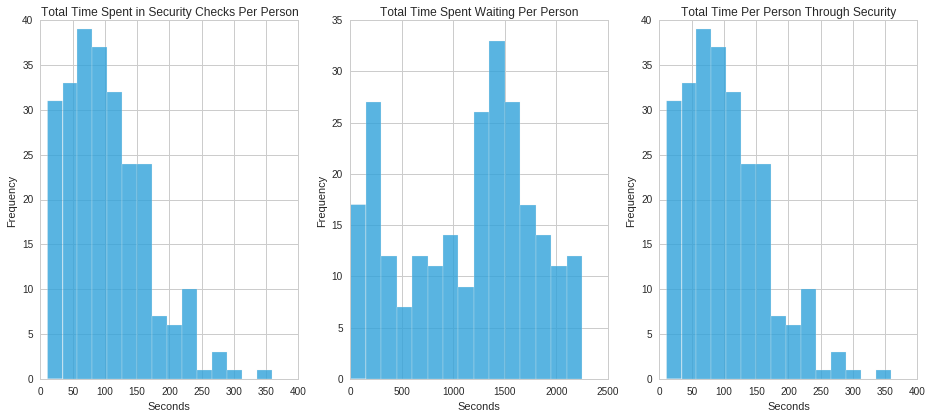

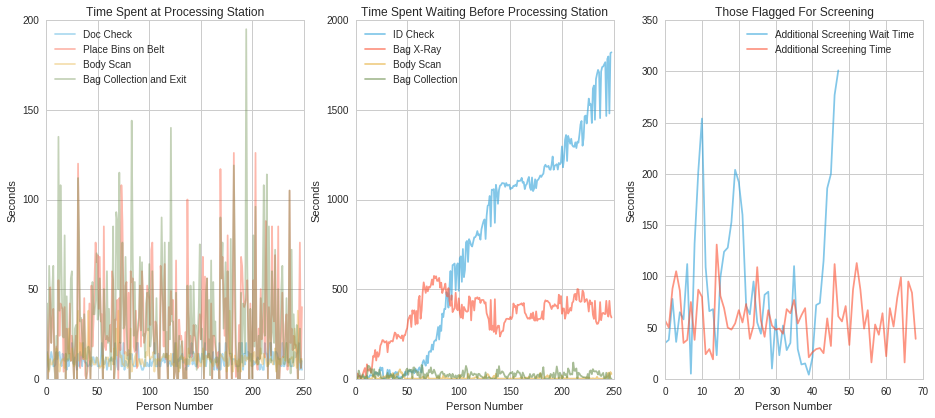

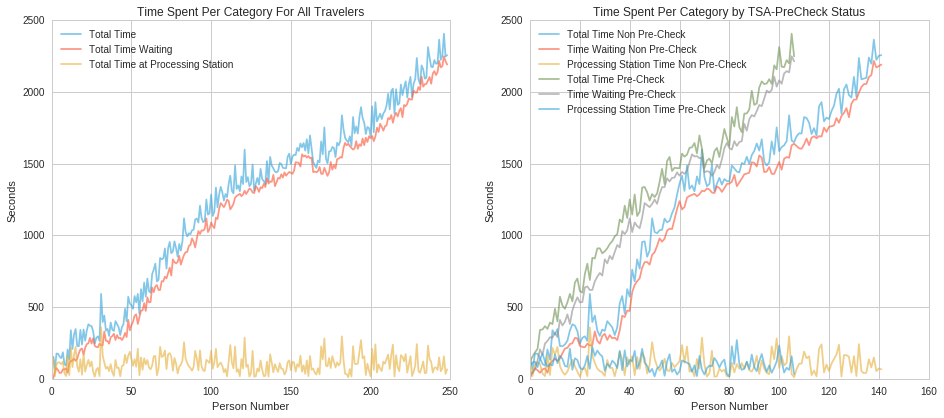

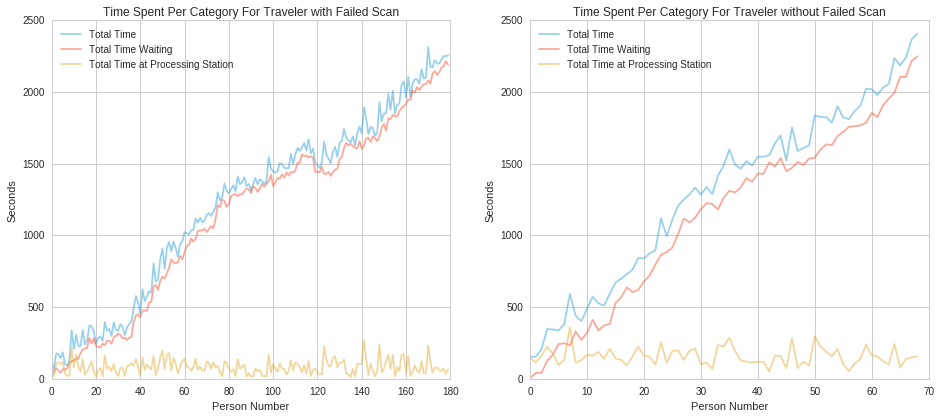

In [11]:
m2.summary_plots()

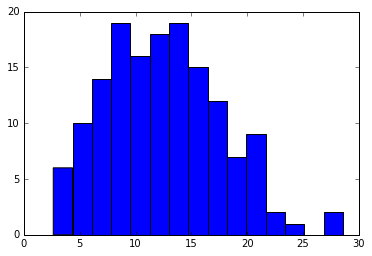

In [15]:
vals = stats.chi.rvs(df=3, loc=0, scale=8, size=150)
plt.hist(vals, bins=15);